In [1]:
import glob
import pickle
import numpy
import tensorflow as tf
import music21 as m21
from music21 import converter, instrument, note, chord
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow.keras.regularizers as regularizers

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create a vocabulary

This function extracts all notes and chords (converted to notes separated by dots) and creates a note / chord array like the following:

    ['C3',
    '0',
    'C3',
    '0',
    '3',
    '8',
    'C3',
    '0',
    '3',
    'B-2',
    'B-3',
    'C3',
    'C4',
    'G#3',
    'G#2',
    '3',
    'G#3',
    'C3',
    'C4',
    'G#2',
    '10',
    'C4',
    'C5',
    '8',
    '8',
    ...
    'C4',
    '7.0']

In [ ]:
def load_midi_into_notes():
    #here I will put all the extracted notes for each file
    notes = []

    #save the indexes in notes in which a new composition started. This will be useful to create consistent sequences, i.e. belonging only to its own composition.
    new_composition_indexs = []
    last_index_new_composition = 0

    #load all the TRAINING midi files to create the vocabulary
    for file in glob.glob("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/midi-dataset/training-midi-dataset/*.mid"):
        
        #add new index to alert that is a new composition
        if last_index_new_composition!=0:
            new_composition_indexs.append(last_index_new_composition)

        #convert the music into a score object
        score = converter.parse(file)

        print("Parsing %s" % file)

        elements_in_part = None

        try: # file has instrument parts
            # given a score that represents the midi, partition it into parts for each unique instrument found
            partitions_by_instrument = instrument.partitionByInstrument(score)
            #accedo part 0. With recurse () I visit all the elements (notes, chords, rests and more) of each of its internal "measures".
            elements_in_part = partitions_by_instrument.parts[0].recurse() 

        except: # file has notes in a flat structure
            elements_in_part = score.flat.notes

        # I scroll through all the elements (notes or chords) picked up
        for element in elements_in_part:
            #if the element is a note...
            if isinstance(element, note.Note):
                #add note to array
                #print("Aggiungo nota: ", element.pitch)
                notes.append(str(element.pitch))
            #if the element is a chord (a set of notes --> es. C4 F4)
            elif isinstance(element, chord.Chord):
                #print("l'elemento è un accordo: ", element)
                # I extract each note from the chord and insert it into the array in the format Note1.Note2.Note3 ... (ex. C4.F4)
                notes.append('.'.join(str(n) for n in element.normalOrder))

    print("::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::Loading training done.")


    with open('/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/1. First architecture for polyphonic music/vocabulary/vocabulary', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes, new_composition_indexs

In [ ]:
notes, new_composition_indexes = load_midi_into_notes()

Parsing ..\..\midi-dataset\training-midi-dataset\ballade_1.mid
Parsing ..\..\midi-dataset\training-midi-dataset\ballade_2.mid
Parsing ..\..\midi-dataset\training-midi-dataset\etude_1.mid
Parsing ..\..\midi-dataset\training-midi-dataset\etude_2.mid
Parsing ..\..\midi-dataset\training-midi-dataset\etude_3.mid
Parsing ..\..\midi-dataset\training-midi-dataset\etude_4.mid
Parsing ..\..\midi-dataset\training-midi-dataset\mazurka_1.mid
Parsing ..\..\midi-dataset\training-midi-dataset\mazurka_10.mid
Parsing ..\..\midi-dataset\training-midi-dataset\mazurka_13.mid
Parsing ..\..\midi-dataset\training-midi-dataset\mazurka_16.mid
Parsing ..\..\midi-dataset\training-midi-dataset\mazurka_19.mid
Parsing ..\..\midi-dataset\training-midi-dataset\mazurka_22.mid
Parsing ..\..\midi-dataset\training-midi-dataset\mazurka_25.mid
Parsing ..\..\midi-dataset\training-midi-dataset\mazurka_28.mid
Parsing ..\..\midi-dataset\training-midi-dataset\mazurka_31.mid
Parsing ..\..\midi-dataset\training-midi-dataset\mazurk

# Create sequences

In [ ]:
def prepare_sequences(notes, n_vocab, new_composition_indexes):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    wait = 0
    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):

        #if the ground truth index is a note/chord that belongs to a new composition
        if (i + sequence_length) in new_composition_indexes:
            wait = sequence_length-1
            continue
        if wait !=0:
            wait = wait -1
            continue

        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]

        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])
    
    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input_training = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # normalize input
    network_input_training = network_input_training / float(n_vocab)
    #one hot encoding of the output
    network_output_training = np_utils.to_categorical(network_output)


    return network_input_training, network_output_training, network_output

In [ ]:
notes

['D3',
 '2',
 'D3',
 '2',
 '5',
 '10',
 'D3',
 '2',
 '5',
 'C3',
 'C4',
 'D3',
 'D4',
 'B-3',
 'B-2',
 '5',
 'B-3',
 'D3',
 'D4',
 'B-2',
 '0',
 'D4',
 'D5',
 '10',
 '10',
 'D4',
 'D5',
 '5',
 '0',
 '2',
 '9',
 '0',
 '0',
 '9',
 '10',
 '9',
 '8',
 '8',
 '8',
 '9',
 '8',
 '7',
 '8',
 '11',
 '11',
 '9',
 '5',
 '5',
 '5',
 '4',
 '7',
 '7',
 '5',
 '4',
 '4',
 '4',
 '5.9',
 'D4',
 'D5',
 '5.9',
 'D4',
 'D5',
 'A4',
 'E3',
 'A4',
 'E3',
 'A3',
 'E4',
 'C5',
 'E4',
 'C5',
 'C5',
 'E2',
 'D4',
 'E4',
 'G#4',
 'C5',
 'B4',
 'A4',
 'A4',
 '9.0.4',
 '9.0.4',
 'E5',
 '9.0.4',
 'E5',
 '9.0.4',
 'D5',
 '9.11.2.5',
 '0.1.2.3.4.5.6.7.8.9.10.11',
 'D5',
 'D4',
 'E2',
 'E4',
 '4.8',
 'C5',
 'B4',
 'A4',
 '9.0.4',
 '9.0.4',
 'A4',
 '9.0.4',
 'F#4',
 '9.11.3',
 '9.11.3',
 'F#4',
 '9.11.3',
 'G#4',
 '4.8.11',
 'E2',
 'E2',
 'G#4',
 'D4',
 'E4',
 'E3',
 'G#4',
 '0.4',
 'B4',
 'A4',
 'D4',
 'E4',
 '9.0.4',
 '9.0.4',
 'A5',
 'A5',
 '0.3.6.9',
 '0.3.6.9',
 'G5',
 '0.2.7',
 'G5',
 '0.2.7',
 'F4',
 'G4',
 'F4',


In [ ]:
# get the vocabulary (unique notes)
n_vocab = len(set(notes))

Create sequences of inputs and their relatives output for training, validation and testing.

For example the input sequences will be something like this:

        array([[[0.48616601],
                [0.48616601],
                [0.48616601],
                ...,
                [0.43280632],
                [0.70750988],
                [0.74901186]],

                [[0.48616601],
                [0.48616601],
                [0.33794466],
                ...,
                [0.70750988],
                [0.74901186],
                [0.48814229]],

while the output will be one-hot-encoded:

        array([[0., 1., 0., ..., 0., 0., 0.],

                [0., 0., 0., ..., 0., 0., 1.],
                
                [1., 0., 0., ..., 0., 0., 0.],
                ...,
                [0., 0., 1., ..., 0., 0., 0.],
                [0., 0., 0., ..., 0., 0., 0.],
                [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)


In [ ]:

network_input_training, network_output_training, network_output_training_to_plot = prepare_sequences(notes, n_vocab, new_composition_indexes)

In [ ]:
print(len(network_input_training))
        

38896


In [ ]:
print(n_vocab)

595


# Model & Training

In [ ]:
model = Sequential()
model.add(LSTM(
    int(n_vocab),
    input_shape=(network_input_training.shape[1], network_input_training.shape[2]),
    return_sequences=True,
))

model.add(LSTM(int(n_vocab/2)))

model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 595)          1420860   
_________________________________________________________________
lstm_5 (LSTM)                (None, 297)               1060884   
_________________________________________________________________
dense_4 (Dense)              (None, 595)               177310    
_________________________________________________________________
activation_4 (Activation)    (None, 595)               0         
Total params: 2,659,054
Trainable params: 2,659,054
Non-trainable params: 0
_________________________________________________________________


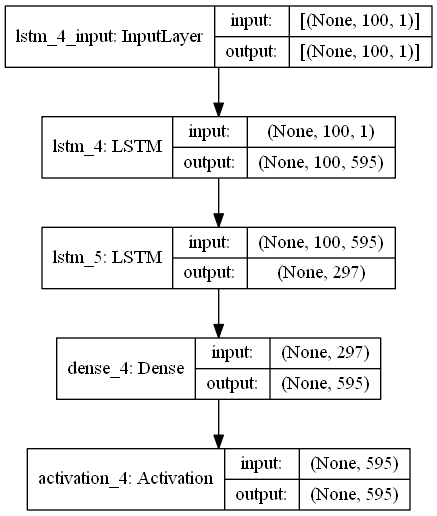

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
filepath = "/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/1. First architecture for polyphonic music/model/chopin-model.hdf5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='accuracy',
    verbose=0,
    save_best_only=True,
    mode='max'
)

callbacks_list = [checkpoint]

history = model.fit(network_input_training, network_output_training, epochs=200, batch_size=64 ,callbacks=callbacks_list, shuffle=True)

Epoch 1/200
608/608 [==============================] - 85s 130ms/step - loss: 5.1313 - accuracy: 0.0232
Epoch 2/200
608/608 [==============================] - 80s 132ms/step - loss: 5.0861 - accuracy: 0.0226
Epoch 3/200
608/608 [==============================] - 82s 134ms/step - loss: 5.3375 - accuracy: 0.0226
Epoch 4/200
608/608 [==============================] - 81s 134ms/step - loss: 5.0964 - accuracy: 0.0262
Epoch 5/200
608/608 [==============================] - 81s 134ms/step - loss: 4.9668 - accuracy: 0.0386
Epoch 6/200
608/608 [==============================] - 82s 134ms/step - loss: 4.9334 - accuracy: 0.0396
Epoch 7/200
608/608 [==============================] - 81s 134ms/step - loss: 4.9115 - accuracy: 0.0424
Epoch 8/200
608/608 [==============================] - 81s 134ms/step - loss: 4.8778 - accuracy: 0.0457
Epoch 9/200
608/608 [==============================] - 82s 135ms/step - loss: 4.8359 - accuracy: 0.0488
Epoch 10/200
608/608 [==============================] - 82s 134m

KeyboardInterrupt: 

In [ ]:
plt.rcParams["figure.figsize"] = [16, 10]
plt.rcParams["figure.autolayout"] = True
pd.DataFrame(history.history).plot()

I lost the training results, so I save the textual output file and extract the results from there by parsing

In [4]:
# writing to file
file1 = open('/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/1. First architecture for polyphonic music/training results/training_results.txt', 'r')
Lines = file1.readlines()
  
count = 0
loss = []
accuracy = []
# Strips the newline character
for line in Lines:
    if len(line) > 50:
        try:
            loss.append(float(line[66:72]))
            accuracy.append(float(line[85:97]))
            print(line[66:72])
        except:
            print(line)

    count += 1
   
df = pd.DataFrame({'loss': loss,
                   'accuracy': accuracy})
df

5.1313
5.0861
5.3375
5.0964
4.9668
4.9334
4.9115
4.8778
4.8359
4.7869
4.7407
4.6852
4.6181
4.5245
4.4323
4.3234
4.2193
4.1222
4.0233
3.9189
3.8213
3.7259
3.6328
3.5426
3.4525
3.3664
3.2771
3.1982
3.1172
3.0427
2.9581
2.8779
2.8054
2.7317
2.6602
2.5865
2.5130
2.4477
2.3789
2.3136
2.2442
2.1691
2.1107
2.0462
1.9755
1.9154
1.8569
1.7937
1.7272
1.6741
1.6122
1.5545
1.5022
1.4498
1.3954
1.3454
1.2983
1.2603
1.2104
1.1656
1.1202
1.0725
1.0377
0.9995
0.9580
0.9250
0.8970
0.8637
0.8366
0.8068
0.7767
0.7513
0.7168
0.6947
0.6693
0.6443
0.6224
0.6048
0.5853
0.5757
0.5440
0.5241
0.5087
0.4968
0.4753
0.4616
0.4454
0.4359
0.4189
0.4078
0.4027
0.3911
0.3772
0.3674
0.3545
0.3437
0.3264
0.3289
0.3138
0.3015
0.3005
0.3051
0.3145
0.3064
0.2870
0.2822
0.2706
0.2681
0.2611
0.2519
0.2532
0.2420
0.2389
0.2347
0.2443
0.2393
0.2312
0.2268
0.2234
0.2200
0.2281
0.2105
0.2164
0.2128
0.2069
0.2102
0.2124
0.2176
0.2155
0.2009
0.2025
0.2000
0.2059
0.1983
0.1957
0.1908
0.1845
0.1759
0.1861
0.1804
0.1786
0.1922
0.1832

,loss,accuracy
0,5.1313,0.0232
1,5.0861,0.0226
2,5.3375,0.0226
3,5.0964,0.0262
4,4.9668,0.0386
...,...,...
188,0.6426,0.8301
189,0.6921,0.8165
190,0.7555,0.7993
191,0.8919,0.7598


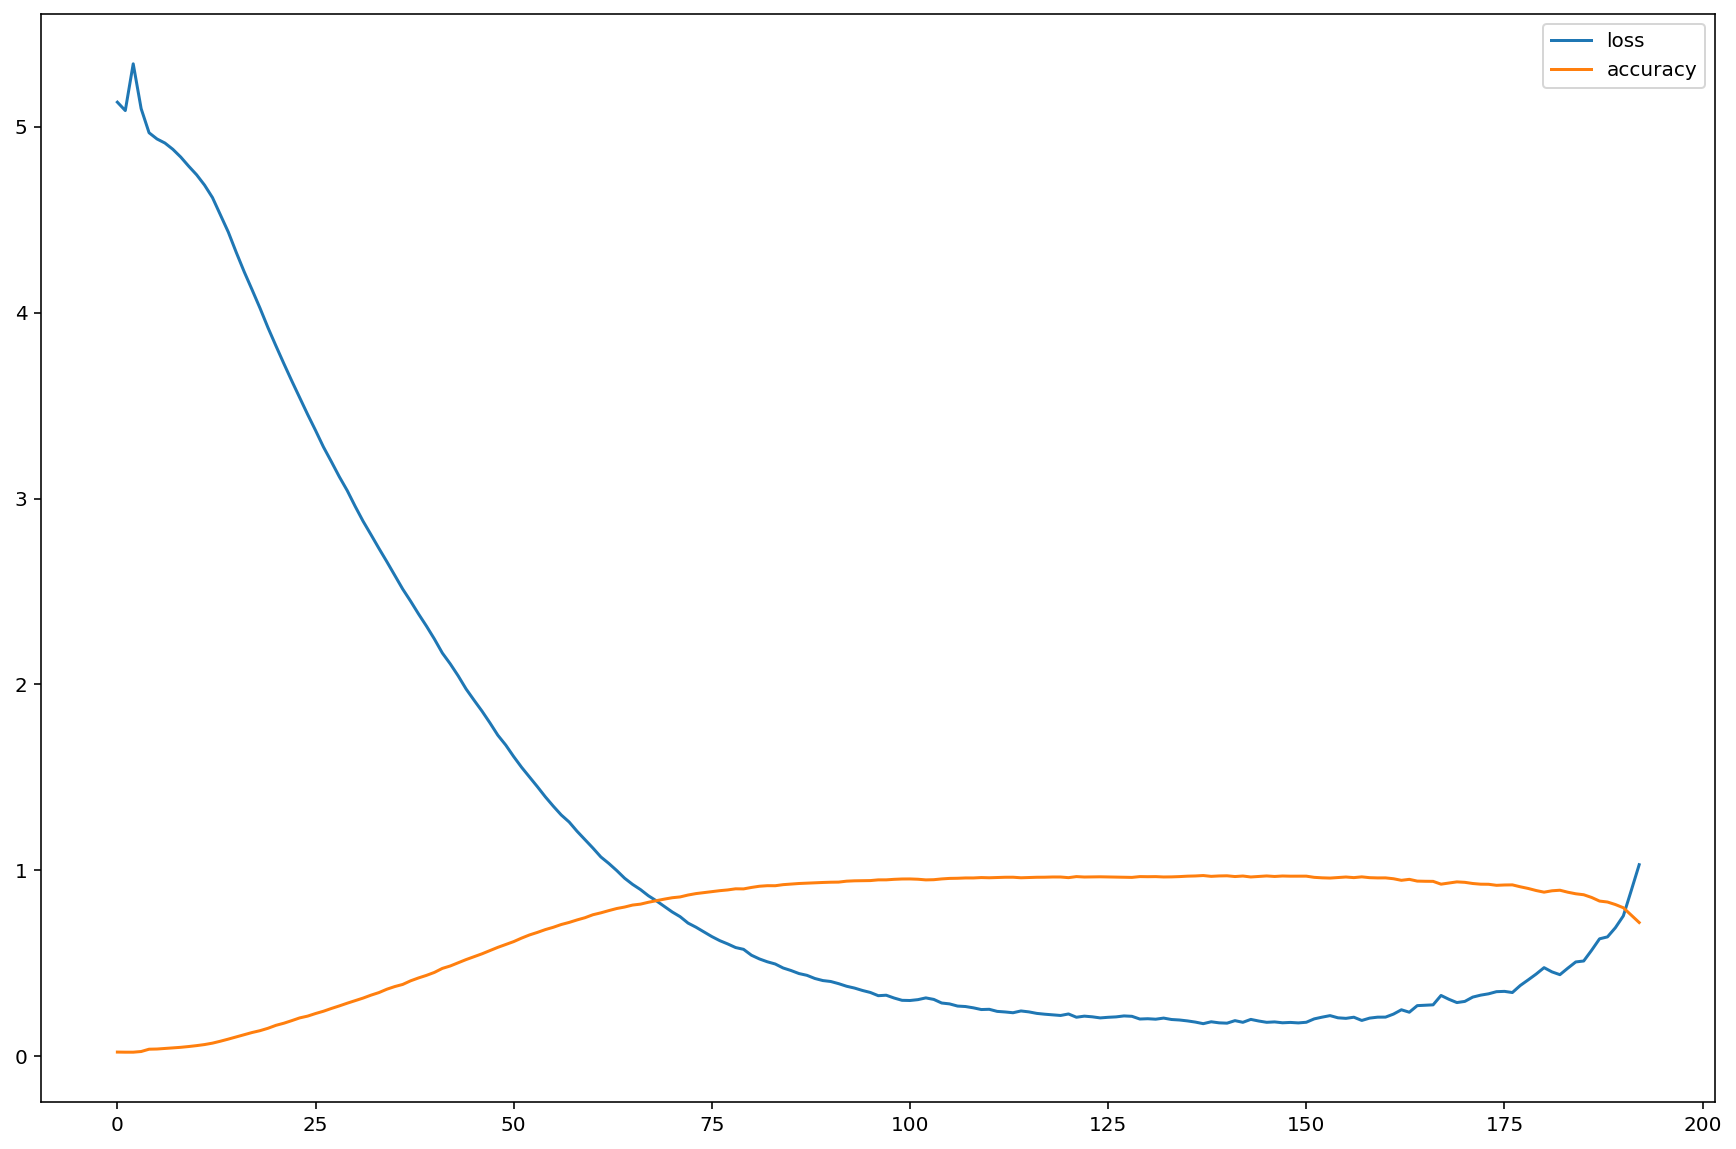

In [7]:
df.plot(figsize=(15,10))